In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mlp import MLP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import MinMaxScaler, _inset_spectra, scaled_tickformat, get_twod_grid
import json 
from botorch.utils.transforms import normalize
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [2]:
DATA_DIR = "./output/"
ITERATION = 7
with open('/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

In [3]:
# Load trained MLP model for p(z|c)
train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%ITERATION, map_location=device)
train_z_mean = torch.load(DATA_DIR+'/train_z_mean_%d.pt'%ITERATION, map_location=device)
train_z_std = torch.load(DATA_DIR+'/train_z_std_%d.pt'%ITERATION, map_location=device)
mlp = MLP(train_x, train_z_mean, train_z_std)
mlp_state_dict = torch.load(DATA_DIR+'/comp_model_%d.pt'%(ITERATION), map_location=device)
mlp.load_state_dict(mlp_state_dict)

# Load trained NP model for p(y|z)
NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%(ITERATION), map_location=device))

design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [4]:
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shapes: (11, 2) (11, 101)
Loading data from iteration 3 with shapes: (11, 2) (11, 101)
Loading data from iteration 4 with shapes: (11, 2) (11, 101)
Loading data from iteration 5 with shapes: (11, 2) (11, 101)
Loading data from iteration 6 with shapes: (11, 2) (11, 101)


In [5]:
# with plt.style.context(pyplot_style):
#     fig, ax = plt.subplots(figsize=(2,2))
#     rids = np.random.randint(expt.comps.shape[0], size=10)
#     for i in rids:
#         ax.plot(expt.wl, expt.spectra_normalized[i,:])
#     plt.savefig("./figures/train_spectra_tiny.png")
#     plt.show()


In [6]:
# x_target = torch.Tensor(np.linspace(0, 1, 100)).to(device)
# x_target = x_target.unsqueeze(1).unsqueeze(0)

# with torch.no_grad(), plt.style.context(pyplot_style):
#     fig, ax = plt.subplots(figsize=(2,2))
#     z_sample = torch.randn((10, N_LATENT)).to(device)
#     for i in range(10):
#         mu, _ = NP.xz_to_y(x_target, z_sample[i,:])
#         ax.plot(expt.wl, mu.cpu().numpy()[0])
#     plt.savefig("./figures/np_samples_tiny.png")
#     plt.show()

In [7]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    
    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_5214/1967543172.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


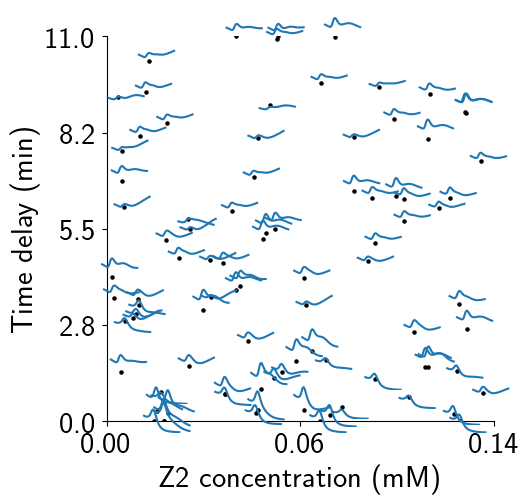

In [8]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    bounds = expt.bounds.cpu().numpy()
    scaler_x = MinMaxScaler(bounds[0,0], bounds[1,0])
    scaler_y = MinMaxScaler(bounds[0,1], bounds[1,1])

    ax.xaxis.set_major_formatter(lambda x, pos : scaled_tickformat(scaler_x, x, pos))
    ax.yaxis.set_major_formatter(lambda y, pos : scaled_tickformat(scaler_y, y, pos))
    train_comps = expt.comps
    norm_train_comps = normalize(train_comps, expt.bounds.cpu().numpy())
    train_spectra = expt.spectra_normalized 
    for i in range(train_comps.shape[0]):
        loc_ax = ax.transLimits.transform(norm_train_comps[i,:])
        ins_ax = ax.inset_axes([loc_ax[0]-0.03,loc_ax[1]-0.03,0.1,0.1])
        ins_ax.plot(expt.t, train_spectra[i,:])
        ins_ax.set_ylim([0, 2.0])
        ins_ax.axis('off')    
    ax.scatter(train_comps[:,0], train_comps[:,1], color='k', s=5)
    prettify_axis(ax)
    plt.savefig("./figures/train_spectra_%d.png"%ITERATION)
    plt.show()